# Malaria Deep Learning Model

### 1. Import Dependencies

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

### 2. Loading Dataset

In [2]:
dataset, dataset_info = tfds.load(
    "malaria",
    with_info=True,
    shuffle_files=True,
    as_supervised=True,
    split=['train'])

In [3]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='C:\\Users\\Timothy Tandt\\tensorflow_datasets\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection 

In [4]:
for data in dataset[0].take(4):
    print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(115, 157, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [5]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [6]:
def splits(dataset: tf.data.Dataset, TRAIN_RATIO: float, VAL_RATIO: float, TEST_RATIO: float):
    DATASET_SIZE = len(dataset)
    
    train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))

    val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))

    test_dataset = val_test_dataset.skip(int(TEST_RATIO*DATASET_SIZE))
    
    return train_dataset, val_dataset, test_dataset

In [7]:
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

### 3. Dataset Visualization

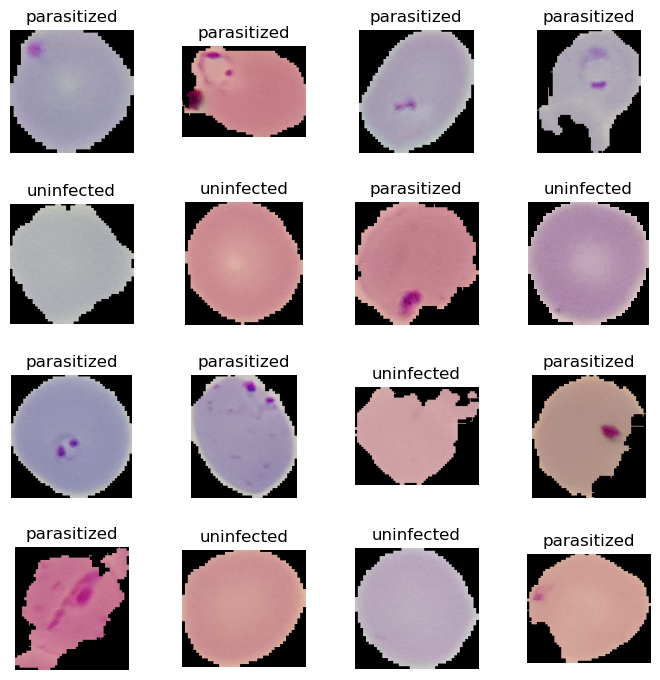

In [8]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

# Iterate over the first 16 elements in the train_dataset
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis("off")
    
# Show the plot
plt.show()

### 4. Data Preprocessing

In [9]:
IM_SIZE = 224
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE)) / 255.0, label

In [10]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [11]:
for image, label in train_dataset.take(1):
    print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [12]:
BATCH_SIZE = 32

In [13]:
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [14]:
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

### 5. Model Creation

##### 5.1 Limit GPU Memory Usage

In [15]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [26]:
from tensorflow.keras.layers import InputLayer, Conv2D, Dense, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [27]:
model = tf.keras.Sequential()

model.add(InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)))

model.add(Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Flatten())

model.add(Dense(100, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(10, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(1, activation="sigmoid"))

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                      

In [29]:
y_true = [0, 1, 0, 0]
y_pred = [0.6, 0.51, 0.94, 0]

bce = BinaryCrossentropy()
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.1007609>

In [34]:
model.compile(optimizer=Adam(learning_rate=0.01), 
              loss=BinaryCrossentropy(),
              metrics="accuracy")

In [35]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20


689/689 [==============================] - 20s 28ms/step - loss: 0.2006 - accuracy: 0.9324 - val_loss: 0.2039 - val_accuracy: 0.9318
Epoch 2/20
689/689 [==============================] - 18s 27ms/step - loss: 0.1713 - accuracy: 0.9452 - val_loss: 0.2295 - val_accuracy: 0.9430
Epoch 3/20
689/689 [==============================] - 18s 27ms/step - loss: 0.1540 - accuracy: 0.9496 - val_loss: 0.5473 - val_accuracy: 0.8581
Epoch 4/20
689/689 [==============================] - 18s 26ms/step - loss: 0.1496 - accuracy: 0.9506 - val_loss: 0.2278 - val_accuracy: 0.9466
Epoch 5/20
689/689 [==============================] - 18s 26ms/step - loss: 0.1318 - accuracy: 0.9576 - val_loss: 0.2115 - val_accuracy: 0.9506
Epoch 6/20
689/689 [==============================] - 18s 27ms/step - loss: 0.1188 - accuracy: 0.9614 - val_loss: 0.2505 - val_accuracy: 0.9379
Epoch 7/20
689/689 [==============================] - 18s 26ms/step - loss: 0.1071 - accuracy: 0.9633 - val_loss: 0.1673 - val_accuracy: 0.9532
Epo

### 6. Plot out the performance

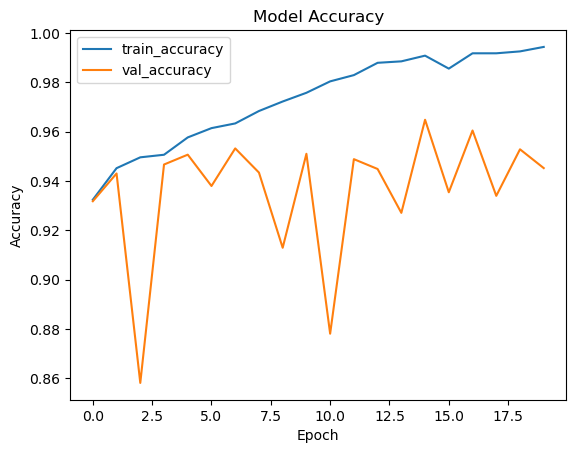

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history["val_accuracy"])

plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

### 7. Model Evaluation and Testing

In [44]:
print(test_dataset, end='\n\n')
print(train_dataset)

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [45]:
test_dataset = test_dataset.batch(1)
test_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [46]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 9s 3ms/step - loss: 0.3370 - accuracy: 0.9474


[0.33704861998558044, 0.9474065899848938]

In [51]:
model_prediction = model.predict(test_dataset.take(1))
model_prediction

array([[5.4738035e-07]], dtype=float32)

In [52]:
result = model_prediction[0][0]
result

5.4738035e-07

In [56]:
def parasite_or_not(x):
    if (x < 0.5):
        return 'Parasatize'
    return 'Uninfected'

In [57]:
parasite_or_not(result)

'Parasatize'

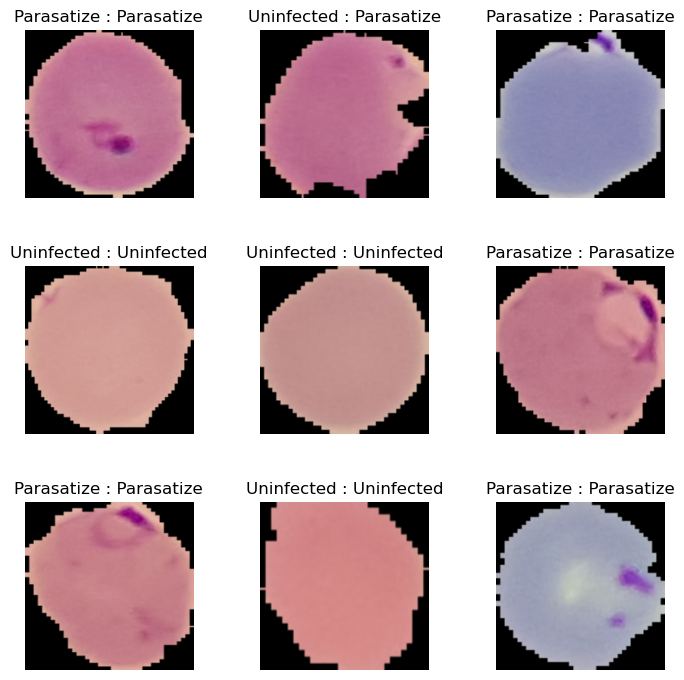

In [59]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

for i, (image, label) in enumerate(test_dataset.take(9)):
    
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0])
    
    title = f"{parasite_or_not(label.numpy()[0])} : {parasite_or_not(model.predict(image)[0][0])}"
    plt.title(title)
    
    plt.axis("off")

### 8. Loading and Saving

In [68]:
import os

In [71]:
current_directory = os.getcwd()
saved_path = os.path.join(current_directory, "model.h5")

In [72]:
model.save(saved_path)

In [73]:
loaded_model = tf.keras.models.load_model(saved_path)
loaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                      